In [1]:
import os
import random
import numpy as np
import scanpy as sc
import anndata as ad

import torch
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP

import NEXUS
from NEXUS.data_process.data_preprocess_cell import Data_process
from NEXUS.cell_emb.model import OneViewVAE, train_model, test_model, embedding, loss_function_oneview, TwoViewVAE, loss_function_twoview

In [2]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

In [3]:
# 需要的参数及定义
input_file_path = "../test_data/test.h5ad"
num_of_highly_variable_genes = 5579
split_ratio = 0.8
output_path = "../test_data/1_cell_emb_output/"
batch_size = 4096
cell_embedding_dim = 64
device_use = "cpu"
view = "oneview"

In [4]:
data_process = Data_process(input_file_path, num_of_highly_variable_genes, split_ratio, batch_size, device_use, process=False)
device = data_process.setup_DDP()

In [5]:
# 数据加载：所有进程都需要加载数据（因为每个进程需要自己的数据副本）
# 但train_test_split只在rank 0执行，然后同步划分结果，确保所有进程使用相同的划分
if data_process.use_ddp:
    # 所有进程都加载数据
    data_process.read_all_adata()
    # 只在rank 0执行划分
    if dist.get_rank() == 0:
        meta_train, meta_test = data_process.train_test_split()
        # 保存划分的索引到临时文件
        import pickle
        train_indices = meta_train.obs.index.tolist()
        test_indices = meta_test.obs.index.tolist()
        with open(output_path + 'temp_train_test_indices.pkl', 'wb') as f:
            pickle.dump((train_indices, test_indices), f)
    # 等待rank 0完成划分
    dist.barrier()
    # 其他进程读取划分索引并创建相同的划分
    if dist.get_rank() != 0:
        import pickle
        with open(output_path + 'temp_train_test_indices.pkl', 'rb') as f:
            train_indices, test_indices = pickle.load(f)
        # 使用相同的索引创建划分
        meta_train = data_process.combined_adata[train_indices].copy()
        meta_test = data_process.combined_adata[test_indices].copy()
    # 再次同步，确保所有进程都准备好
    dist.barrier()
    # 清理临时文件（只在rank 0）
    if dist.get_rank() == 0:
        if os.path.exists(output_path + 'temp_train_test_indices.pkl'):
            os.remove(output_path + 'temp_train_test_indices.pkl')
else:
    # 单GPU模式，正常执行
    data_process.read_all_adata()
    meta_train, meta_test = data_process.train_test_split()

In [6]:
# DDP_sampler
train, test, train_iter, test_iter, train_iter_emb, test_iter_emb, sampler_train, sampler_test = data_process.data_sampler(meta_train, meta_test)

In [7]:
# 模型定义
if view == "oneview":
    model = OneViewVAE(num_of_highly_variable_genes, cell_embedding_dim)
    loss_function=loss_function_oneview
elif view == "twoview":
    model = TwoViewVAE(num_of_highly_variable_genes, cell_embedding_dim, method = "gaussian")
    loss_function=loss_function_twoview
model = model.to(device)

# 只在DDP模式下包装模型
if data_process.use_ddp:
    model = DDP(model)
    print("Model wrapped with DDP")
else:
    print("Model running in single GPU/CPU mode (no DDP)")

Model wrapped with DDP


In [8]:
model = train_model(model, train_iter, test_iter, sampler_train, loss_function, device)
print(f'Training finished')

Epoch 1/500
Train Loss: 0.3543 | Test Loss: 0.2182
更新最佳模型，当前最佳验证损失: 0.2182
Epoch 2/500
Train Loss: 0.1931 | Test Loss: 0.1676
更新最佳模型，当前最佳验证损失: 0.1676
Epoch 3/500
Train Loss: 0.1580 | Test Loss: 0.1458
更新最佳模型，当前最佳验证损失: 0.1458
Epoch 4/500
Train Loss: 0.1381 | Test Loss: 0.1282
更新最佳模型，当前最佳验证损失: 0.1282
Epoch 5/500
Train Loss: 0.1228 | Test Loss: 0.1156
更新最佳模型，当前最佳验证损失: 0.1156
Epoch 6/500
Train Loss: 0.1119 | Test Loss: 0.1072
更新最佳模型，当前最佳验证损失: 0.1072
Epoch 7/500
Train Loss: 0.1054 | Test Loss: 0.1027
更新最佳模型，当前最佳验证损失: 0.1027
Epoch 8/500
Train Loss: 0.1014 | Test Loss: 0.0990
更新最佳模型，当前最佳验证损失: 0.0990
Epoch 9/500
Train Loss: 0.0991 | Test Loss: 0.0959
更新最佳模型，当前最佳验证损失: 0.0959
Epoch 10/500
Train Loss: 0.0940 | Test Loss: 0.0906
更新最佳模型，当前最佳验证损失: 0.0906
Epoch 11/500
Train Loss: 0.0882 | Test Loss: 0.0846
更新最佳模型，当前最佳验证损失: 0.0846
Epoch 12/500
Train Loss: 0.0831 | Test Loss: 0.0822
更新最佳模型，当前最佳验证损失: 0.0822
Epoch 13/500
Train Loss: 0.0798 | Test Loss: 0.0773
更新最佳模型，当前最佳验证损失: 0.0773
Epoch 14/500
Train Lo

In [9]:
# 保存模型（DDP模式下只在rank 0保存，单GPU模式下直接保存）
is_main_process = True  # 标记是否是主进程
if data_process.use_ddp:
    is_main_process = (dist.get_rank() == 0)
    if is_main_process:
        torch.save(model.module, output_path + "VAE.pth")
        print(f"Save done!")
    # 分布式同步
    dist.barrier()
    # 清理DDP进程组（训练完成后）
    dist.destroy_process_group()
else:
    torch.save(model, output_path + "VAE.pth")
    print(f"Save done!")

Save done!


In [10]:
# embedding阶段：切换到单进程模式（使用CPU或单GPU）
# 注意：这里需要重新加载模型，因为DDP已经销毁
# 只在主进程（rank 0）或单GPU模式下执行embedding
if is_main_process:
    device = torch.device("cuda:0")
    
    if view == "oneview":
        model = OneViewVAE(num_of_highly_variable_genes, cell_embedding_dim)
    elif view == "twoview":
        model = TwoViewVAE(num_of_highly_variable_genes, cell_embedding_dim, method = "gaussian")
    checkpoint = torch.load(output_path + "VAE.pth", map_location=torch.device('cpu'), weights_only=False)
    model.load_state_dict(checkpoint.state_dict())
    
    # embedding
    adata_test_raw, _ = embedding(model, test_iter_emb, test, view)
    adata_train_raw, _ = embedding(model, train_iter_emb, train, view)
    adata_test_raw.obs = meta_test.obs
    adata_train_raw.obs = meta_train.obs
    
    adata_all_raw = ad.concat({'train': adata_train_raw, 'test':adata_test_raw}, label = 'train_test')
    adata_all_raw.write(output_path + 'VAE_embedded.h5ad')
    print(f'Embedding finished')

Embedding finished


In [11]:
import scanpy as sc
import NEXUS
from NEXUS.plotting.emb_plot import cell_embedding_umap_plot

In [12]:
output_path = "../test_data/1_cell_emb_output/"
adata_emb = sc.read_h5ad(output_path + 'VAE_embedded.h5ad')
batch = "sample_ID"
label = "cell_type"

E:\NEXUS\NEXUS\plotting\emb_plot.py:10: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=resolution)


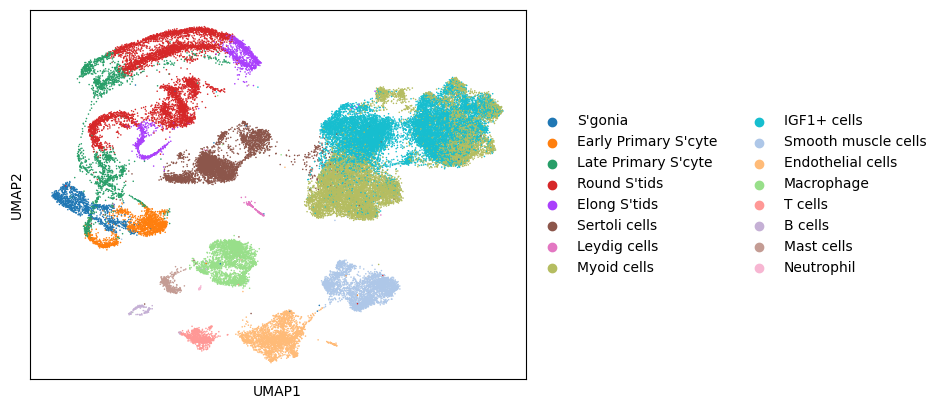

2025-11-27 15:20:57,715 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-11-27 15:21:09,519 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-11-27 15:21:10,052 - harmonypy - INFO - Iteration 1 of 10
2025-11-27 15:21:37,059 - harmonypy - INFO - Iteration 2 of 10
2025-11-27 15:22:03,508 - harmonypy - INFO - Iteration 3 of 10
2025-11-27 15:22:32,488 - harmonypy - INFO - Converged after 3 iterations


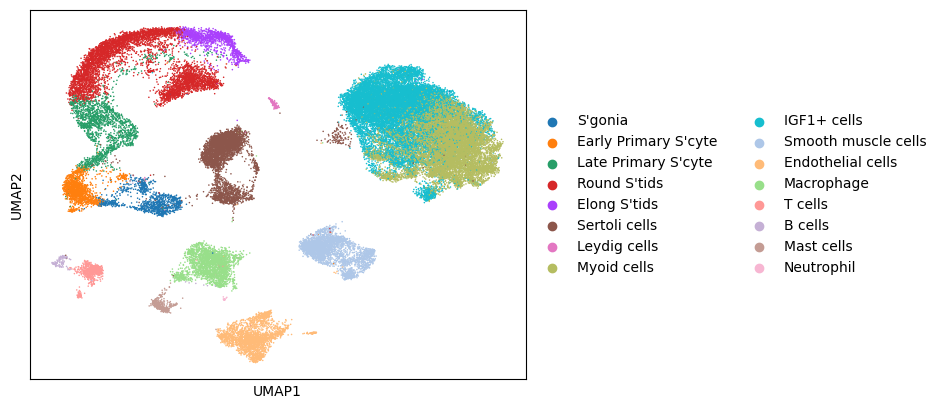

In [13]:
adata_umap = cell_embedding_umap_plot(adata_emb, label, batch, harm = True)

In [14]:
adata_umap.write(output_path + 'VAE_embedded.h5ad')